# Dynamic Systems

All physical systems that store and transform energy are all dynamic systems that cannot react instantaneously
to an external solicitation. This because if an energy transformation were to be instantaneous, it would require
an infinite power ($P=dW/dt$), which is impossible to deliver.

These systems are characterized by their capacity to act or not in a stable way, in a fast way, in an oscillating
way, ...

When the underlying physics of dynamic systems is sufficiently known, we have mathematical models capable
of describing their temporal behavior: differential equations. Matlab allows the integration of linear differential
equations with constant coefficients (LTI: Linear Time Invariant), expressed in different forms (and thus their
numerical solutions), but also of non-linear differential equations (for which the most appropriate simulation tool
is Simulink but it will not be discussed here).

As an illustration, let's take the following example: if a force applied to a mass is at the origin of an acceleration,
it is by integrating this force (divided by the mass) that we will obtain the velocity as a function of time and, by
integrating the velocity, we will obtain the distance traveled. So we express the derivatives, Matlab integrates
them. That's easy!

We will continue this tutorial with this well known example: the system mass ($M$), spring ($K$), damper ($R_f$), of
position $y$, subjected to an external force $u$.

![](./12_image1.png)

with $M = 0.5 kg$; $R_f=0.2kg/s$ and $K=1kg/s^2$

The first step in the analysis of a physical system is to write down the laws of physics that govern its operation.

Here, the dynamic equilibrium equation of the forces ($\sum_i F_i = M \cdot a$) on the mass $M$ is writen : $M \frac{d^2y}{dt} + R_f \frac{dy}{dt} + Ky = u$ or in a normalized way : $\frac{d^2y}{dt^2} + \frac{R_f}{M}\frac{dy}{dt} + \frac{K}{M}y = \frac{1}{M}u$

Recall that this differential equation can, **only because it is an LTI equation**, be transformed into a polynomial expression as a function of the variable "$s$" by passing in the Laplace domain.

This passage in the Laplace domain is done with the Laplace transform, and allows us :

- to make our life much easier : we will manipulate algebraic equations rather than differential equations
- to quickly judge the dynamics and stability of the system by identifying its poles (the roots of the
denominator)
- to obtain directly the harmonic response of the system, i.e. in sinusoidal regime after the transient phase,
by replacing "$s$" by "$j\omega$".

Our differential equation becomes, by the Laplace transform : $s^2Y(s) + \frac{R_f}{M}sY(s) + \frac{K}{M}Y(s) = \frac{1}{M}U(s)$

The transfer function is the ratio of the output y to the input u : $$H(s) = \frac{Y(s)}{U(s)} = \frac{\frac{1}{M}}{s^2 + \frac{R_f}{M}s + \frac{K}{M}}$$

This transfer function $H(s)$ will serve as an illustrative example throughout this tutorial. As soon as we talk about the $H(s)$ system, it will be good to remember that the physics behind this transfer function is this mass-spring-damper system.

*NB: If the equation relating to this system were a non-linear differential equation, it would be necessary to work with the tools that are briefly presented at the end of this tutorial, or else it would be necessary to accept to work with small variations of the quantities around an operating point of this system to be able to apply the Laplace transform. This amounts to linearizing this system and allows to use all the theory related to transfer functions. This linearization approach is the one most frequently encountered in industry. Let's remember that the most frequent objective in industry is to control a system with a controller. And it turns out that the LTI tools allowing the implementation of this control are much more understandable and simple to implement than the non linear techniques, which explains why these solutions are preferred.*

## Transfer functions creation (continuous or discrete) in Python

Python knows the "$s$" (for the continuous systems) and "$z$" (for the discrete ones) variables. We can therefore create the transfer function as a fraction of polynomials of "$s$".

But first, the "$s$" variable should be created, which is done with the instruction `tf` from the `control` module:

In [1]:
import control as ct

s=ct.tf('s')

This variable (Laplace variable) can then be manipulated to write the polynomials of the transfer functions. In the case of the above example, by replacing the parameters by their values, this gives :

In [2]:
assert s is not None  # to please the type checker
H = 2/(s**2+0.4*s+2)
H # to make jupyter display the transfer function

TransferFunction(array([2]), array([1. , 0.4, 2. ]))

Note that the instruction `tf` can be used in another way, without creating the variable $s$, by giving it the coefficients of the polynomials in $s$: `ct.tf(num,den)` where `num` is the polynomial of the coefficients in $s$ of the numerator and `den` that of the denominator.

It is also possible to create a transfer function in Python by providing the zeros, the poles and the gain, via the instruction `ct.zpk`.

These ways of doing things being less intuitive, we will prefer the method based on the creation of the variable $s$, and refer you to the `control` module help for the rest.

In the same way, we can create a transfer function not in continuous but in discrete, by creating beforehand the variable $z$, as well as the sampling time `Ts` of application. Unlike Matlab, in Python you must use the `ct.tf(num, den, Ts)` form to create a discrete-time transfer function. To create the $z$ variable, choose the `num` and `den` so that the transfer function simplifies to $z$:

$$z = \frac{1z + 0}{1}$$

In [3]:
Ts = 0.1 # this is the sampling time, expressed in seconds
z = ct.tf([1, 0], [1], Ts) 
z

TransferFunction(array([1, 0]), array([1]), 0.1)

In [4]:
assert z is not None
Hz=2/(z**2+0.4*z+2)  # Discrete transfer function, with the sample time
                     # (Ts) = 0.1s, as the "z" variable was created specifying
                     # this value
Hz

TransferFunction(array([2]), array([1. , 0.4, 2. ]), 0.1)

**Pay attention**, it is important to note that the transfer function `Hz` created above is not the equivalent of the transfer function `H` in discrete, even if the numerator and denominator are identical!

To discretize the system `H` and obtain the discrete version, we can use the "continue to discrete" command, specifying the continuous system to be discretized and the sampling period Ts : `Sysd = ct.c2d(Sysc,Ts)`.

By default, the discretization method used is that of the zero-order blocker:

In [5]:
Hz = ct.c2d(H, Ts) # We get a discrete transfert function (using the z variable).
                   # The polynomials (numerator and denominator) are different from
                   # the ones we had in continuous H.
Hz

TransferFunction(array([0.0098516 , 0.00972103]), array([ 1.        , -1.94121681,  0.96078944]), 0.1)

We can see here that the global order of `Hz` is $z^{-1}$, which expresses well that the influence of the input on the output will be perceived only after a sampling time.

## Finding and plotting a transfer function poles and zeros

As already mentioned, the poles of this transfer function correspond to the roots of the denominator (which can be real or complex conjugates), and characterize the dynamics of the system and its stability. Indeed, when we use the inverse Laplace transform to return to the time domain, the answer we obtain will be a sum of exponentials defined by the position of the poles in the Laplace domain:

- The real part of the poles will define the speed of decay or growth of the exponential : $e^{t \cdot p_r}$ with $p_r$ being the real part of the pole : One can understand that poles with a positive real part will give rise to increasing exponentials, and thus to a system which will not converge and will be unstable. **A system will be stable if all its poles are located to the left of the imaginary axis in the complex plane**. One can also observe that $e^{t \cdot p_r}$ can be classically written $e^{\frac{t}{\tau}}$ when dealing with differential equations, and that therefore the real part of a pole is the inverse of its time constant : the further the pole is from the imaginary
axis, the faster the associated time constant will be, and the less its influence on the transient will be important. Conversely, a pole close to the imaginary axis will be considered as a dominant pole.
- The imaginary part of the poles will lead in the time domain to a complex exponential, or a sinusoid. This implies that **if there are complex poles conjugated in the complex plane, it will lead us to have an oscillating response in the time domain**. The imaginary part of the poles defines the pulsation of this sine. And the combination of the real and imaginary parts defines what the overshoot will be when responding to a step.

The poles can be obtained easily, with the roots function of `numpy`:

In [6]:
import numpy as np

assert isinstance(H, ct.TransferFunction)
np.roots(H.den[0][0])

array([-0.2+1.4j, -0.2-1.4j])

or via the 'poles' method of the transfer function object :

In [7]:
assert isinstance(H, ct.TransferFunction)
H.poles()   # or ct.poles(H)

array([-0.2+1.4j, -0.2-1.4j])

Similarly, if the system had zeros, we could find them by looking for the roots of the numerator :

In [8]:
assert isinstance(H, ct.TransferFunction)
np.roots(H.num[0][0])  # We get an empty vector as the numerator has no zero
                       # in this specific case.

array([], dtype=float64)

or via the `zeros` method.

In [9]:
H.zeros()

array([], dtype=complex128)

As mentioned above, we can create a transfer function from zeros, poles, and gain with the `ct.zpk` function. The gain used for this function **is not the static gain** but is instead the ratio between the coefficients of the highest order terms of the numerator and denominator of the transfer function.

In [10]:
G_zpk = H.num[0][0][0] / H.den[0][0][0]
G_zpk

np.float64(2.0)

In [11]:
ct.zpk(H.zeros(), H.poles(), G_zpk)

TransferFunction(array([2.]), array([1. , 0.4, 2. ]))

The `ct.pzmap` function allows to draw the poles and zeros of a system in the complex plane :

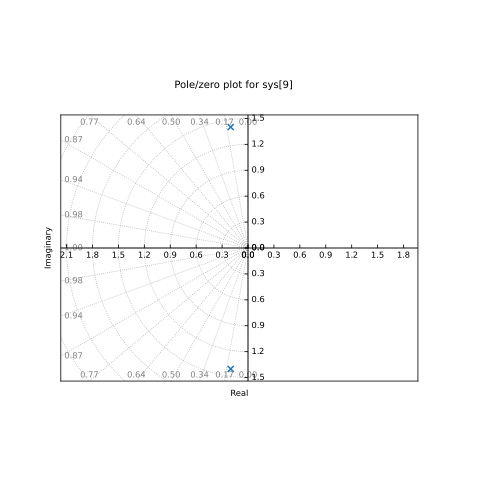

In [12]:
from matplotlib import pyplot as plt

# better plots in jupyter
%config InlineBackend.figure_formats = ['svg']

ct.pzmap(H, grid=True)
plt.show()


### What if we work with a discrete system ?

We have the same tools to find and draw the poles and to draw. Remember that for a discrete system, the stability condition is that the poles are located in a circle of unit radius centered at $(0,0)$.

In [13]:
Hz.poles()

array([0.97060841+0.13677998j, 0.97060841-0.13677998j])

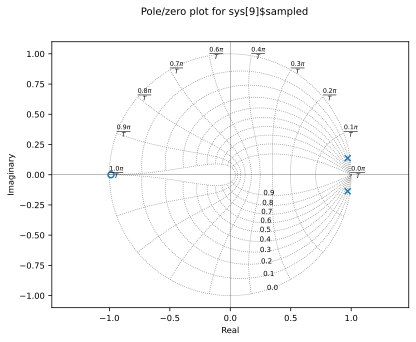

In [14]:
ct.pzmap(Hz, grid=True)
plt.show()

## Handling of LTI dynamic objects

When the output of the `H1` system is connected to the input of the `H2` system, the global transfer function is obtained by the series connection, thus mathematically by a multiplication of the 2 transfer functions.

In the time domain, the convolution integral should have been used instead of this simple product in the Laplace domain.

![](./12_image2.png)

In [15]:
assert s is not None

H5 = 1 / (5*s + 1)
H6=1 / (10*s + 1)
H5 * H6

TransferFunction(array([1]), array([50, 15,  1]))

... their parallelism is obtained with the " + ":

![](./12_image3.png)

In [16]:
H5 + H6

TransferFunction(array([15,  2]), array([50, 15,  1]))

When a feedback loop is closed, the Matlab feedback command is used to obtain the transfer function of the looped system:

![](./12_image4.png)

In [17]:
ct.feedback(H5, H6)

TransferFunction(array([10,  1]), array([50, 15,  2]))

or without the feedback function :

In [18]:
H5 / (1 + H5*H6)

TransferFunction(array([50, 15,  1]), array([250, 125,  25,   2]))

When manipulating these transfer functions, Matlab does not simplify the poles and zeros on its own initiative when possible.

In [19]:
assert s is not None
H2 = (s + 2) / ((s + 3) * (s + 5))
H3 = (s + 3) / (s + 4)
H3 * H2

TransferFunction(array([1, 5, 6]), array([ 1, 12, 47, 60]))

This often occurs when multiple operations are performed on transfer functions. We can therefore simplify the expression, which is done with the `ct.minreal` function:

In [20]:
ct.minreal(H3*H2)

1 states have been removed from the model


TransferFunction(array([1., 2.]), array([ 1.,  9., 20.]))

## Temporal responses to a step, an impulse and any input signal (lsim)

With the `ct.step_response` function, the step response of the system will be calculated from $t=0s$ until the transients are done, regardless of which tool the dynamic object was created with (`ct.zpk`, `ct.tf`, ...)

It is worth noting that the `ct.step_response` function executes a unitary amplitude step at time $t=0s$.

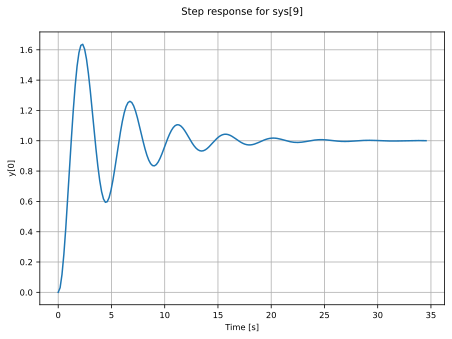

In [21]:
ct.step_response(H).plot()
plt.grid()
plt.show()

By default, Python defines the length of the time vector itself, so as to show the whole transient. It is also possible to impose the time over which the step response must be calculated and plotted.

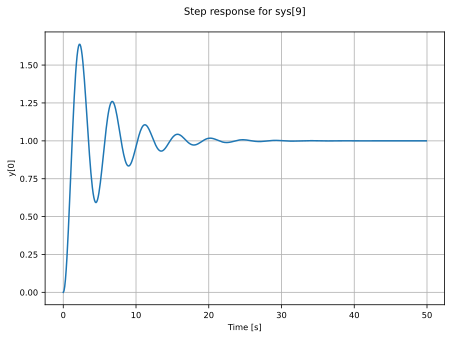

In [22]:
T = np.arange(0, 50, 0.1)
ct.step_response(H, T).plot()
plt.grid()
plt.show()

One can also get the data of the step response in 2 vectors `t` & `y`, instead of seeing the step response beeing plotted :

In [23]:
t, y = ct.step_response(H)
y

array([0.        , 0.03048509, 0.11730535, 0.25137608, 0.42138673,
       0.61463475, 0.81788618, 1.01820945, 1.20373391, 1.36429257,
       1.4919182 , 1.58117297, 1.6293031 , 1.6362212 , 1.6043292 ,
       1.53820333, 1.44416965, 1.32980318, 1.20338605, 1.07336001,
       0.94780693, 0.83398634, 0.73795429, 0.6642807 , 0.6158757 ,
       0.59392773, 0.59794973, 0.62592306, 0.67452393, 0.73941292,
       0.81556594, 0.89762378, 0.980238  , 1.05839244, 1.12768276,
       1.18454001, 1.22638852, 1.25173316, 1.26017555, 1.25236306,
       1.22987822, 1.19507946, 1.15090589, 1.1006605 , 1.04778624,
       0.99564896, 0.94733991, 0.90550822, 0.87223151, 0.84892981,
       0.83632495, 0.83444483, 0.8426692 , 0.85981137, 0.88422843,
       0.91395151, 0.94682665, 0.9806573 , 1.01333957, 1.04298265,
       1.06800822, 1.08722412, 1.09986982, 1.10563271, 1.10463631,
       1.09740296, 1.08479512, 1.0679401 , 1.04814404, 1.02680095,
       1.00530272, 0.98495538, 0.96690629, 0.95208584, 0.94116

In [24]:
t

array([ 0.        ,  0.17712193,  0.35424386,  0.53136579,  0.70848772,
        0.88560965,  1.06273158,  1.23985351,  1.41697544,  1.59409737,
        1.7712193 ,  1.94834123,  2.12546316,  2.30258509,  2.47970702,
        2.65682895,  2.83395088,  3.01107281,  3.18819474,  3.36531667,
        3.5424386 ,  3.71956053,  3.89668247,  4.0738044 ,  4.25092633,
        4.42804826,  4.60517019,  4.78229212,  4.95941405,  5.13653598,
        5.31365791,  5.49077984,  5.66790177,  5.8450237 ,  6.02214563,
        6.19926756,  6.37638949,  6.55351142,  6.73063335,  6.90775528,
        7.08487721,  7.26199914,  7.43912107,  7.616243  ,  7.79336493,
        7.97048686,  8.14760879,  8.32473072,  8.50185265,  8.67897458,
        8.85609651,  9.03321844,  9.21034037,  9.3874623 ,  9.56458423,
        9.74170616,  9.91882809, 10.09595002, 10.27307195, 10.45019388,
       10.62731581, 10.80443774, 10.98155967, 11.1586816 , 11.33580353,
       11.51292546, 11.6900474 , 11.86716933, 12.04429126, 12.22

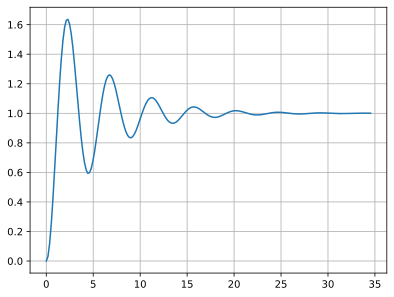

In [25]:
assert t is not None
assert y is not None

plt.plot(t, y)
plt.grid()
plt.show()

**NB:** You will have noticed that the static gain of the system is 1, whereas the zero() instruction had announced a gain (not static) of 2: this gain was that of the numerator for the transfer function written in the Evans form (unit coefficient for the most important power in $s$ of the denominator).

It is good to remember that the static gain, no matter in which form the system is presented, can always be calculated by replacing $s$ by 0 in the transfer function.

In Python, we can get the static gain with the `ct.dcgain` function :

In [26]:
ct.dcgain(H)

np.float64(1.0)

### What about the discrete time response ?

The step response of a discrete system can also be plotted using the same step command :

In [27]:
Hz

TransferFunction(array([0.0098516 , 0.00972103]), array([ 1.        , -1.94121681,  0.96078944]), 0.1)

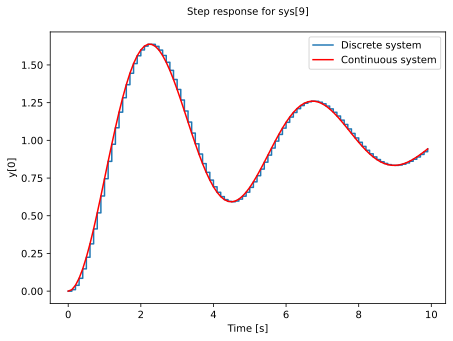

In [28]:
T = np.arange(0, 10, 0.1)
t_Hz, y_Hz = ct.step_response(Hz, T)
# The plot method smooth the graph by default so we use the `plt.step` function to show the discretization
plt.step(t_Hz, y_Hz, where='post', label="Discrete system") 
ct.step_response(H, T).plot('r', label="Continuous system")
plt.legend()
plt.show()

One can see the sampling time (0.1 second) on the step response, but also the similarities between the continuous and discrete systems. Note that the discrete response is late compared to the continuous one, the delay beeing the half of the sampling period. It should also be noted that the values are not known between 2 sampling times. A more correct representation of the actually known information would be obtained by showing
the values at the sampling times only, using the `plt.stem` function:

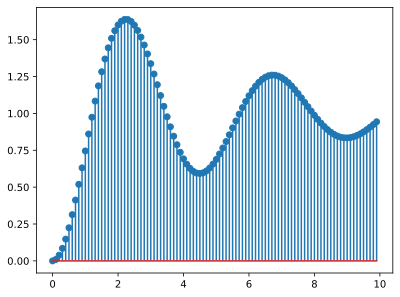

In [29]:
plt.stem(t_Hz, y_Hz)
plt.show()

The **impulse response** is obtained with the `ct.impulse_response` function :

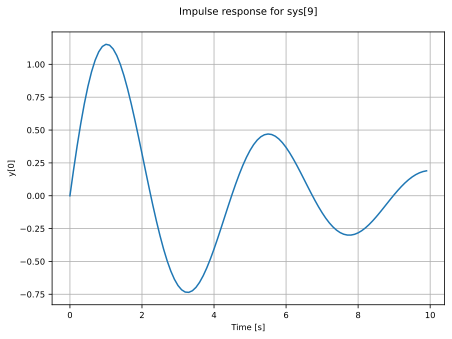

In [30]:
ct.impulse_response(H, T).plot()
plt.grid()
plt.show()

and with the same instruction for a discrete system :

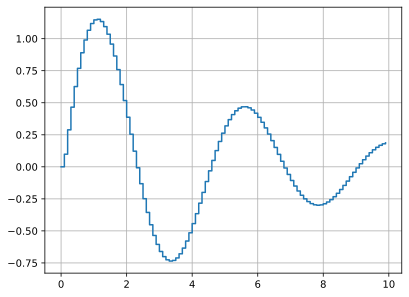

In [31]:
t_Hz, y_Hz = ct.impulse_response(Hz, T)
plt.step(t_Hz, y_Hz, where='post', label="Discrete system")
plt.grid()
plt.show()

## Time-related response to any signal

The `control` package of Python integrates functions to obtain the temporal responses to Dirac impulse or unit step solicitations. But how to obtain the response to any solicitation?

We will have to use the `ct.forced_response` function, having previously created the input signal manually. This way of doing things can be used to calculate the response to any signal

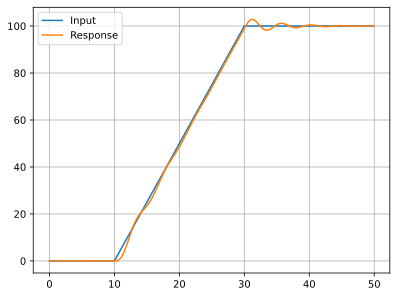

In [32]:
t = np.arange(0, 50, 0.1)

u = 5 * t - 50
u[t < 10] = 0
u[t >= 30] = 5 * 30 - 50

_, y = ct.forced_response(H, t, u)

plt.plot(t, u, label="Input")
plt.plot(t, y, label="Response")
plt.grid()
plt.legend()
plt.show()

### Exercise

We now suggest to solve the next exercise that deals with the creation and manipulation of transfer functions.

[12_1_FT_Manipulation.ipynb](./12_1_FT_Manipulation.ipynb)

### Exercise

We now propose to do an exercise that deals with the identification of a system according to a model (a transfer function) imposed by its step response.

[12_2_idf_FT_VDG.ipynb](./12_2_idf_FT_VDG.ipynb)

## Frequency response: the Bode plot

In addition to the temporal analysis of systems, the harmonic (or frequency) analysis allows to obtain information about the behavior of a system that the temporal analysis can not give directly:

- The frequency analysis of the system in open loop is frequently used to deduce the behavior it will have in closed loop,
- The frequency analysis allows to quantify the stability of a system constituted with a feedback (closed loop),
- Knowing that any signal can be reconstructed as a sum of sines of different frequencies, phase and amplitude, the frequency analysis allows to understand some temporal behaviors.

The principle of frequency analysis of a system is as follows: the system is solicited with a sinusoidal input. Knowing that the system is LTI, we know that we will obtain a sinusoidal signal (oscillating at the same frequency as the input signal) at the output of this same system, but that it may have a different amplitude from the input signal, and that a phase shift may appear between this output signal and the input signal. These 2 phenomena are directly linked to the time constants of the system, which, as a reminder, are an image of its inertia. We will therefore analyze how the amplitude ratio of the signals, called the gain (amplitude of the output
signal compared to that of the input signal), and how the phase shift evolves when we vary the frequency of the input signal while keeping its amplitude constant.

It is important to note that this analysis is done in "steady state": we consider that the sinusoidal input signal of the system is present for a sufficiently long time so that all the transients of the system are over.

This analysis is made easier by the use of transfer functions: indeed, it is enough to replace "$s$" by "$j\omega$", which generates a complex fraction. Then to see how the norm and the phase of this one evolve when $\omega$ varies. Let's do it for our example:

Replacing "$s$" by "$j\omega$" in the transfer function, we get the next complex fraction : $$\frac{2}{(j\omega)^2 + 0.4(j\omega) + 2}$$

© JM Rousseau - D Rouchard - Q Lurkin

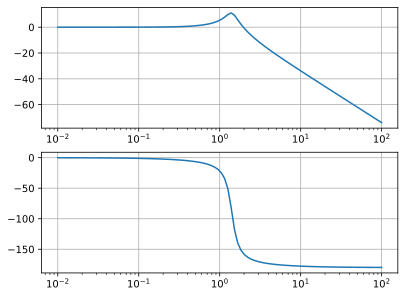

In [33]:
w = np.logspace(-2, 2, 100) # Vector of the frequencies for which I want to know the behavior of the system

c=2/((1j*w)**2+0.4*(1j*w)+2) # Matrix of complex fractions for the corresponding frequencies

m=180*np.angle(c)/np.pi # Phase in degrees
g=20*np.log10(np.abs(c)) # Gain in dB

plt.figure()
plt.subplot(2, 1, 1)
plt.semilogx(w, g)
plt.grid()
plt.subplot(2, 1, 2)
plt.semilogx(w, m)
plt.grid()
plt.show()

We have manually rebuild the Bode diagram, which represents the way the gain and phase of the output signal of a system evolve as a function of the frequency of the input signal.

In Python, you can use the `ct.bode` function to directly get the same result:

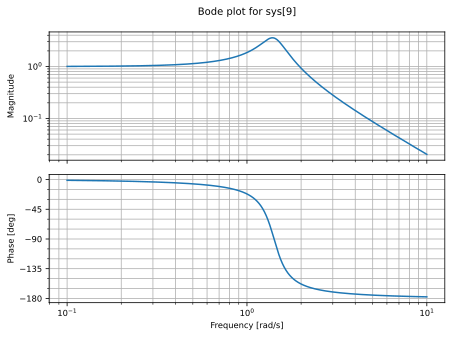

In [34]:
ct.bode(H)
plt.show()

As for the temporal responses, it is possible to impose the frequencies at which we want to plot the Bode diagram:

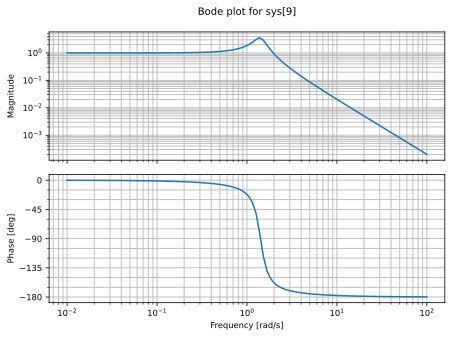

In [35]:
ct.bode(H, w)
plt.show()

And also we can use the `ct.frequency_response` function to recover the phase and gain for a given frequency:

In [36]:
w_spec = 5
mag, phase, omega = ct.frequency_response(H, w_spec)
print(mag) # gain not in dB
print(phase) # phase in radian
print(omega)

[0.08662962]
[-3.05485431]
[5.]


In [37]:
magdB = 20*np.log10(mag[0])
phaseDeg = 180*phase[0]/np.pi

print(f"{magdB=}\n{phaseDeg=}")

magdB=np.float64(-21.2466721769861)
phaseDeg=np.float64(-175.03025927188972)


This allows us to read the value of the static gain of the system, which is read at the zero frequency :

In [38]:
static_gain, _, _ = ct.frequency_response(H, 0)
print(static_gain[0])

1.0


We can see that the static gain of the system is equal to 1 in our case. Remember that it is because the Bode diagram is drawn for a sinusoidal steady state regime that the fact of imposing a zero frequency can read the static gain.

One of the great interests of the representation of systems in the Bode diagram is that it is possible to simply sum the curves of the different elements composing the direct chain (the open loop) of the complete system. This is made possible by the use of the logarithmic axis in this Bode diagram. Indeed, we remember that $log(ab) = log(a) + log(b)$. This property applies only to the Bode diagram, not to the Nyquist diagram which will be described below.

Thus, the frequency response of a transfer function $G(s) = \frac{5}{s^2+5s+6}$ which can be written as the product of 3 independent transfer functions $5$, $\frac{1}{s+3}$ and $\frac{1}{s+2}$ can be easily plotted by drawing the diagrams corresponding to the 3 simple functions and summing them:

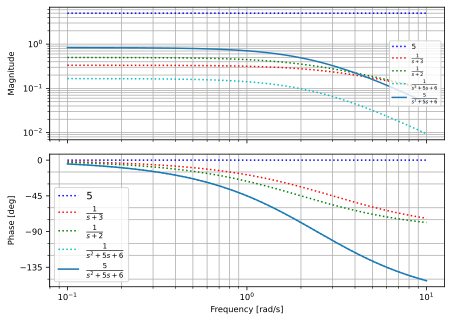

In [39]:
ct.bode(ct.tf(5, 1), None, ':b', label="$5$")
ct.bode(ct.tf(1, [1, 3]), None, ':r', label=r"$\frac{1}{s+3}$")
ct.bode(ct.tf(1, [1, 2]), None, ':g', label=r"$\frac{1}{s+2}$")
ct.bode(ct.tf(1, [1, 5, 6]), None, ':c', label=r"$\frac{1}{s^2+5s+6}$")
ct.bode(ct.tf(5, [1, 5, 6]), label=r"$\frac{5}{s^2+5s+6}$")
plt.legend()
plt.grid()
plt.show()

Time for an exercise using the Bode plot and illustrating that it provides the harmonic response only in steady state:

[12_3_sine_wave_sollicitation.ipynb](./12_3_sine_wave_sollicitation.ipynb)

Let's start a new exercise: solving an electric circuit in steady state and transient:

[12_4_AC_Electrical_circuit_2.ipynb](./12_4_AC_Electrical_circuit_2.ipynb)

## Nyquist plot

The Nyquist diagram represents exactly the same thing as the Bode diagram, but instead of representing the gain and phase as a function of frequency, it is a polar representation on a single curve.

We can imagine that it is the plot of the end of a rotating vector whose origin is placed in $[0;0]$ and whose amplitude and phase vary with frequency. We specify with an arrow on the curve obtained in which direction to follow a growing $\omega$. It should be noted that the gain is not calculated in dB, unlike the Bode diagram.

In the case of our system, for a zero frequency, the gain is unity and the phase zero. And for an infinite frequency, the gain is zero and the phase is -180°. This can be seen on the following diagram.

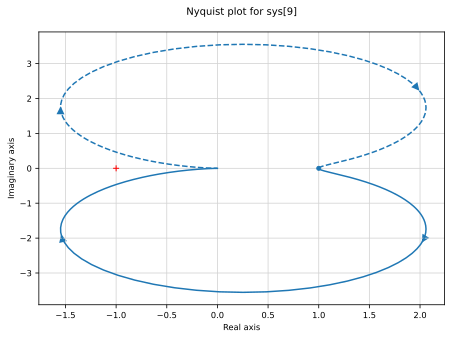

In [40]:
ct.nyquist(H) # diagram of the gain versus the phase (where the frequency does not appear)
plt.show()

Time for a new exercice combining Bode and Nyquist plots :

[12_5_Nyquist.ipynb](./12_5_Nyquist.ipynb)

### Black-Nichols plot

Last representation of the frequency response of a system, the Black-Nichols diagram is drawn in a Cartesian graph with in abcissa the phase of the system, and in ordinate the gain expressed in dB, for an increasing pulse.

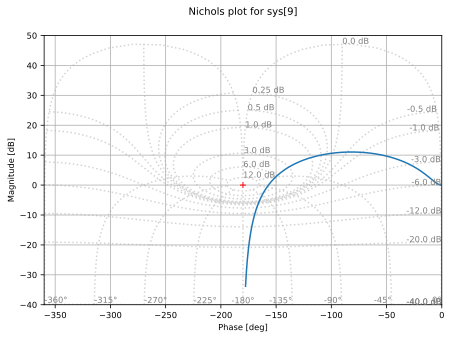

In [41]:
ct.nichols(H)
plt.grid()
plt.show()

**Example: Study of the current transient of a non-ideal choke connected to the network, at a phi phase of the sinusoid**

In [42]:
f = 50             # Network frequency
w = 2 * np.pi * f
L = 0.005          # Self [F]
R = 0.05           # Resistance [R]
Zself = R + 1j*w*L # Impedance for w = 2*pi*f
Yself = 1 / Zself
U = 240            # Voltage
I = U * Yself
I                  #Current ==> Almost only reactive.

(4.858494131071419-152.6340946968309j)

In [43]:
abs(I)   # Its a complex number, let's compute its norm

152.71140045570536

This value could have been obtained by creating the transfer function corresponding to this system, and looking at the harmonic response for the desired pulse:

In [44]:
G = ct.tf(1,[L, R])
G

TransferFunction(array([1]), array([0.005, 0.05 ]))

In [45]:
mag, phase, _ = ct.frequency_response(G, 100*np.pi)
print(mag)
print(phase*180/np.pi)

[0.6362975]
[-88.17683428]


The current amplitude is therefore the gain multiplied by the voltage amplitude:

In [46]:
U * mag

array([152.71140046])

This current is correct but only in the steady state, i.e. after the inrush current. As mentioned earlier, the harmonic analysis via Bode, Nyquist, etc. tools only concerns the steady state.

However, the question arises as to how long it takes to reach the steady state?

Let's study the Inrush current for a phase $\pi$ of the voltage at the onset by means of the transfer function, but in time then, by means of the `ct.forced_response` function (it is not possible to do otherwise this time)

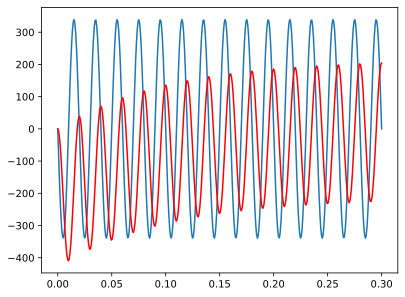

In [47]:
t = np.linspace(0, 0.3, 400)
phi = np.pi     # the phase of the voltage at the time of switching on

u=240*np.sqrt(2)*np.sin(100*np.pi*t+phi) # the instantaneous network voltage

s = ct.tf('s')
Yself = 1 / (R + s*L)
_, a = ct.forced_response(Yself, t, u)     # a = the current = u*Y

plt.figure()
plt.plot(t, u)
plt.plot(t, a, 'r')
plt.show()